# Fitted Parameter Accuracy

This notebook examins the accuraccy of fitted SN parameters when assuming different levels of atmospheric variabitily in the fitting process.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy.stats.stats import pearsonr


## Parsing Data

Results from the analysis pipeline are written to disk over multiple files. We read data from each file and concatenate the results. 

Values that are not fit for are masked using the value `-99.99`. For conveniance, we replace these values with `nan` in the below example. 

For a full overview of the output file data model, see the [data model documentation](https://lsstdesc.org/SN-PWV/overview/data_model.html).


In [2]:
def add_derived_values(pipeline_data):
    """Calculate some useful values and add them to a dataframe of pipeline data
    
    Args:
        pipeline_data (DataFrame): Pipeline data returned by ``load_pipeline_data``
        
    Returns:
        A copy of the given dataframe with added columns
    """
    
    pipeline_data = pipeline_data.copy()
    for param in ('z', 't0', 'x0', 'x1', 'c'):
        pipeline_data[f'delta_{param}'] = pipeline_data[f'fit_{param}'] - pipeline_data[param]
        pipeline_data[f'delta_{param}_norm'] = pipeline_data[f'delta_{param}'] / pipeline_data[f'{param}']
    
    return pipeline_data


In [3]:
def get_combined_data_table(directory, key, pattern='*.h5'):
    """Return a single data table from directory of HDF5 files
    
    Returns concatenated tables from each of the files.
    
    Args:
        directory (Path): The directory to parse data files from
        key        (str): Key of the table in the HDF5 files
        pattern    (str): Include results from all files matching the regex pattern
        
    Returns:
        A pandas datafram with pipeline data
    """

    if not (h5_files := list(directory.glob(pattern))):
        raise ValueError(f'No h5 files found in {directory}')
    
    dataframes = []    
    for file in h5_files:
        with pd.HDFStore(file, 'r') as datastore:
            dataframes.append(datastore.get(key))
            
    return pd.concat(dataframes).set_index('snid')


def load_pipeline_data(directory, pattern='*.h5', derived=True):
    """Return the combined input and output parameters from a pipeline run
    
    Args:
        directory (Path): The directory to parse data files from
        pattern    (str): Include results from all files matching the regex pattern
        
    Returns:
        A pandas datafram with pipeline data
    """
    
    sim_params = get_combined_data_table(directory, '/simulation/params', pattern=pattern)
    fit_results = get_combined_data_table(directory, '/fitting/params', pattern=pattern)
    fit_status = get_combined_data_table(directory, 'message', pattern=pattern)

    # THe join order is important here. Left most tables are a superset of rightmost tables
    pipeline_data = fit_status.join(fit_results).join(sim_params)

    # Join results for failed fit results will be nan.
    return_data = pipeline_data.replace(-99.99, np.nan)
    if derived:
        return_data = add_derived_values(return_data)
        
    return return_data


In [4]:
data_dir = Path('.').resolve().parent / 'data' / 'analysis_runs' / 'validation'


We load data from different simulation and fitting conditions. The fitting process may not be able to find a successful minimum for each lgiht-curve. We print a summary of the success rate.

In [5]:
sim_4_fit_4 = load_pipeline_data(data_dir, pattern='pwv_sim_4_fit_4*')

print('Summary of simulation success for SNe:')
sim_4_fit_4.success.value_counts()


Summary of simulation success for SNe:


True     957
False     43
Name: success, dtype: int64

In [6]:
sim_epoch_fit_4 = load_pipeline_data(data_dir, pattern='pwv_sim_epoch_fit_4*')

print('Summary of simulation success for SNe:')
sim_epoch_fit_4.success.value_counts()


Summary of simulation success for SNe:


True     957
False     43
Name: success, dtype: int64

In [7]:
sim_epoch_fit_seasonal = load_pipeline_data(data_dir, pattern='pwv_sim_epoch_fit_seasonal*')

print('Summary of simulation success for SNe:')
sim_epoch_fit_seasonal.success.value_counts()


Summary of simulation success for SNe:


True     957
False     43
Name: success, dtype: int64

In [8]:
sim_epoch_fit_epoch = load_pipeline_data(data_dir, pattern='pwv_sim_epoch_fit_epoch*')

print('Summary of simulation success for SNe:')
sim_epoch_fit_epoch.success.value_counts()


Summary of simulation success for SNe:


True     957
False     43
Name: success, dtype: int64

## Accuracy of Fitted Parameters


We examine the distribution of fitted parameter residuals for different fitting conditions.

In [9]:
def clean_data(data):
    """Drop SN with failed fits and apply quality cuts
    
    Cuts defined here are applied to all plots in the remainder
    of the notebook.
    
    Args:
        data (DataFrame): Pipeline output data
    
    Returns:
        A copy of the data that has been cleaned
    """
    
    return data[data.success]


In [10]:
def plot_parameter_distribution(
    data, 
    params=('x0', 'x1', 'c'),
    xlims=((0, 3.0e-5), (-4, 4), (-.5, .5)),
    bins=(np.linspace(0, 3.0e-5, 100), 100, 100),
    sharey=True,
    figsize=(20, 5)
):
    """
    
    Args:
        data (DataFrame): Pipeline data to use for the plot
        params   (tuple): Tuple of parameter names to plot distributions for
        bins       (int): Number of bins to use when building histograms
        figsize  (tuple): Size of the generated figure
    """
    
    data = clean_data(data)
    
    fig, axes = plt.subplots(1, len(params), figsize=figsize, sharey=sharey)
    for param, xlim, binn, axis in zip(params, xlims, bins, axes):
        axis_data = data[param]
        median = axis_data.median()
        std = axis_data.std()
        
        hist = axis.hist(axis_data, bins=binn, label=f'STD {std:.2f}')
        axis.axvline(median, linestyle='--', color='k', label=f'Median: {median:.2f}')
        
        axis.set_xlabel(param, fontsize=16)
        axis.set_xlim(xlim)
        axis.legend()

    axes[0].set_ylabel('Number of SNe')
    

In [11]:
def plot_parameter_accuracy(
    data, 
    params=('x0', 'x1', 'c'),
    bins=np.linspace(-1, 1, 200),
    sharey=False,
    figsize=(20, 5)
):
    """Plot histograms of the normalized difference between 
    simulated and fitted model parameters.
    
    Args:
        data (DataFrame): Pipeline data to use for the plot
        params   (tuple): Tuple of parameter names to plot distributions for
        bins     (Array): Bins to use when building histograms
        figsize  (tuple): Size of the generated figure
    """
        
    data = clean_data(data)
    
    fig, axes = plt.subplots(1, len(params), figsize=figsize, sharey=sharey)
    for param, axis in zip(params, axes):
        xmin = min(bins)
        xmax = max(bins)
        
        axis_data = data[f'delta_{param}_norm']
        axis_data = axis_data[xmin <= axis_data][axis_data <= xmax]
        median = axis_data.median()
        mean = axis_data.mean()
        std = axis_data.std()
        
        hist = axis.hist(axis_data, bins=bins, label=f'STD {std:.2f}')
        axis.axvline(median, linestyle='--', color='k', label=f'Median: {median:.2f}')
        
        axis.set_xlabel(r'$\frac{' + param + r'_{sim} - ' + param + '_{fit}}{' + param + '_{sim}}$', fontsize=16)
        axis.set_xlim(xmin, xmax)
        axis.legend()
        
    axes[0].set_ylabel('Number of SNe')


Distribution of input parameters


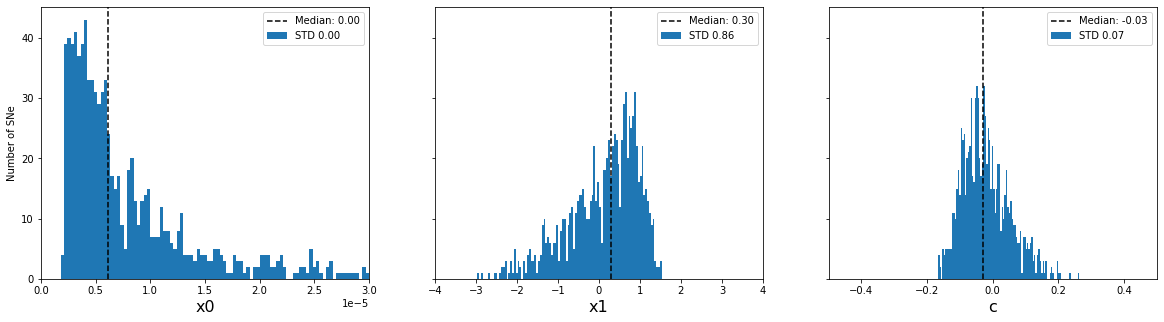

Accuracy of fitted parameters


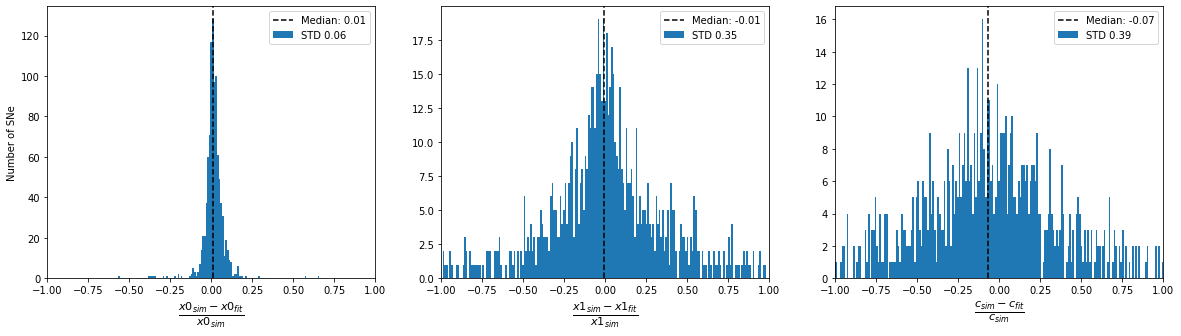

In [12]:
print('Distribution of input parameters')
plot_parameter_distribution(sim_epoch_fit_4)
plt.show()

print('Accuracy of fitted parameters')
plot_parameter_accuracy(sim_epoch_fit_4)


Distribution of input parameters


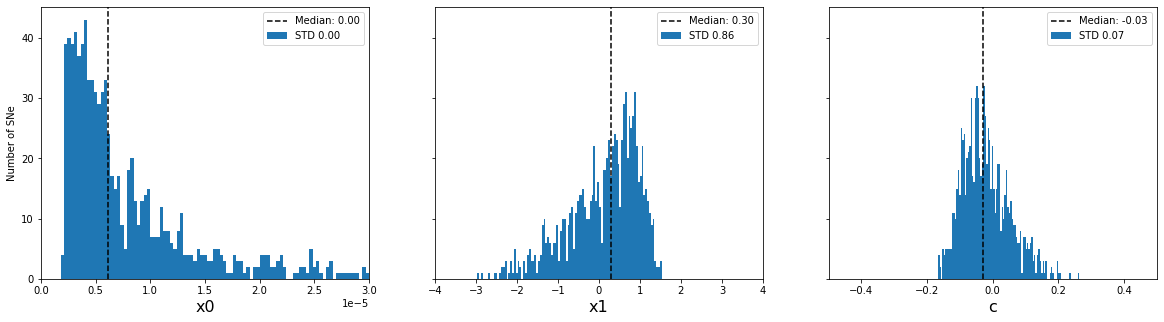

Accuracy of fitted parameters


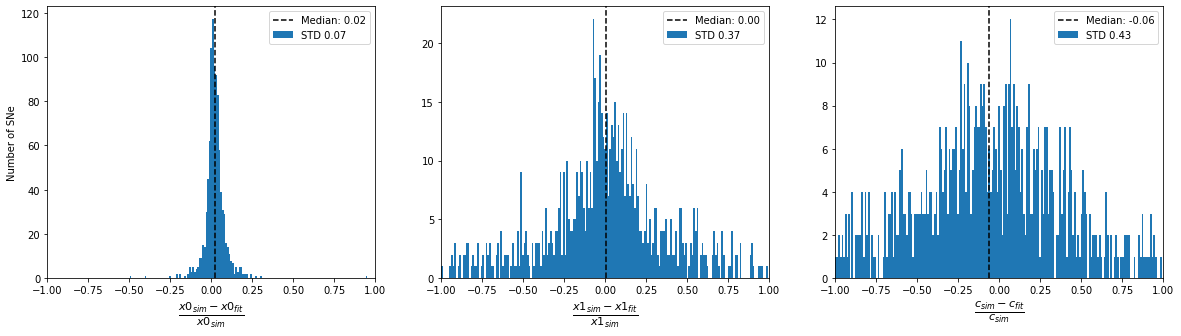

In [13]:
print('Distribution of input parameters')
plot_parameter_distribution(sim_epoch_fit_seasonal)
plt.show()

print('Accuracy of fitted parameters')
plot_parameter_accuracy(sim_epoch_fit_seasonal)


Distribution of input parameters


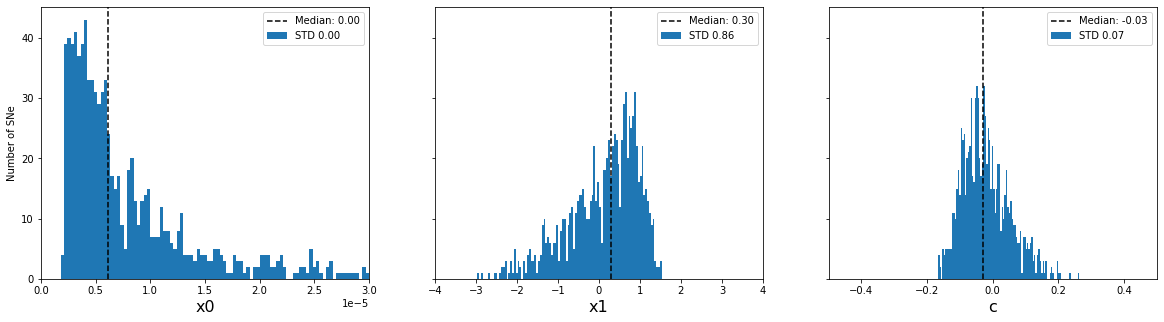

Accuracy of fitted parameters


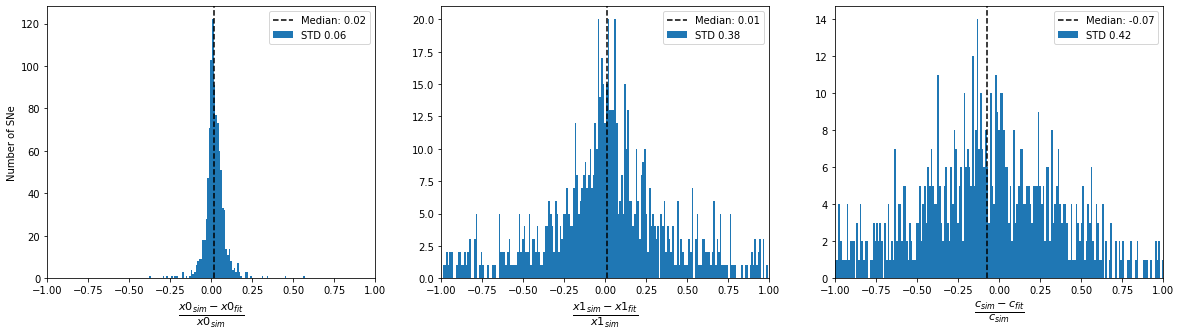

In [14]:
print('Distribution of input parameters')
plot_parameter_distribution(sim_epoch_fit_epoch)
plt.show()

print('Accuracy of fitted parameters')
plot_parameter_accuracy(sim_epoch_fit_epoch)


## Correlation Between Residuals and SN Properties

We check for correlations between residuals in the fitted parameters and other supernova properties.

In [15]:
def calc_correlations(
    data,
    params=('delta_t0', 'delta_x0', 'delta_x1', 'delta_c'),
    properties=('z', 't0', 'x0', 'x1', 'c', 'ra', 'dec'),
):
    """Calculate the pearson correlation coefficiant between the
    accuracy in fitted parameters and SN properties
    
    Args:
        data   (DataFrame): Pipeline data to use for the plot
        params     (tuple): Model parameters to calculate covariance for
        properties (tuple): Name of SN properties to calculate covariance with
        
    Returns:
        - A dataframe with covariance values
        - A dataframe with p values
    """
    
        
    data = clean_data(data)
    
    corr_for_param = dict()
    p_for_param = dict()
    for param in params:

        corr_for_prop = dict()
        p_for_prop = dict()
        for prop in properties:
            x = data[prop]
            y = data[param]
            corr_for_prop[prop], p_for_prop[prop] = pearsonr(x, y)

        corr_for_param[param] = pd.Series(corr_for_prop)
        p_for_param[param] = pd.Series(p_for_prop)

    return pd.DataFrame(corr_for_param), pd.DataFrame(p_for_param)


In [16]:
def plot_correlations(
    corr_data,
    params=('delta_t0', 'delta_x0', 'delta_x1', 'delta_c'),
    properties=('z', 't0', 'x0', 'x1', 'c', 'ra', 'dec'),
    figsize=(8, 8),
    vmin=None,
    vmax=None,
    label='',
    cmap=None
):
    """Create a heatmap of correlation data
    
    Args:
        corr_data (DataFrame): Data returned from ``calc_correlations``
        params        (tuple): Model parameters used to calculate covariance
        properties    (tuple): Name of SN properties used to calculate covariance
        figsize       (tuple): Size of the generated figure
        vmin            (int): Lower bound of the color bar
        vmax            (int): Upper bound of the color bar
        label           (str): The label of the color bar
        cmap            (str): Name of the matplotlib color map to use
    """
    
    fig, axis = plt.subplots(figsize=figsize)
    im = axis.imshow(corr_data, vmin=vmin, vmax=vmax, cmap=cmap)

    cbar = axis.figure.colorbar(im, ax=axis)
    cbar.ax.set_ylabel(label, rotation=-90, va="bottom")

    axis.set_xticks(np.arange(corr_data.shape[1]))
    axis.set_yticks(np.arange(corr_data.shape[0]))
    axis.set_xticklabels(params)
    axis.set_yticklabels(properties)
    

Correlation matrix:
     delta_t0  delta_x0  delta_x1   delta_c
z         NaN -0.021312 -0.003353 -0.030628
t0        NaN -0.016767  0.022884 -0.008252
x0        NaN  0.399608 -0.048634  0.039499
x1        NaN  0.009479  0.047773  0.041796
c         NaN  0.046033  0.049560  0.045537
ra        NaN -0.038020 -0.008513 -0.011467
dec       NaN  0.042037 -0.071100  0.048980


/home/djperrefort/miniconda3/envs/SN-PWV/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


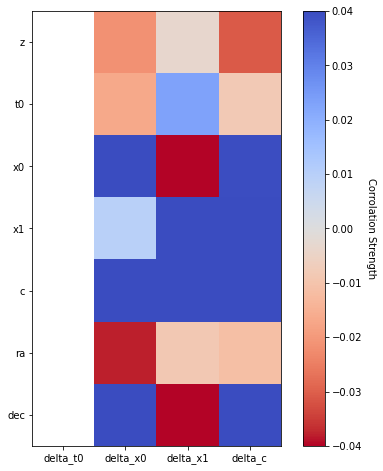

In [17]:
corr, p = calc_correlations(sim_epoch_fit_4)

print('Correlation matrix:')
plot_correlations(corr, vmin=-.04, vmax=0.04, label='Corrolation Strength', cmap='coolwarm_r')
print(corr)
plt.show()


p-value matrix:
     delta_t0      delta_x0  delta_x1   delta_c
z         NaN  5.102102e-01  0.917497  0.343910
t0        NaN  6.044322e-01  0.479501  0.798767
x0        NaN  5.351855e-38  0.132725  0.222159
x1        NaN  7.696231e-01  0.139731  0.196408
c         NaN  1.547531e-01  0.125501  0.159255
ra        NaN  2.399768e-01  0.792529  0.723115
dec       NaN  1.938372e-01  0.027847  0.129987


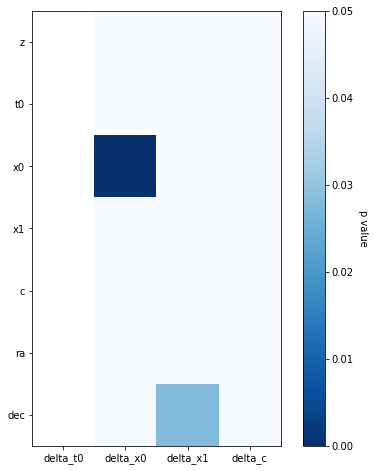

In [18]:
print('p-value matrix:')
plot_correlations(p, label='p value', cmap='Blues_r', vmax=0.05)
print(p)
plt.show()

In [19]:
def density_plot(
    data,
    y_vals=('x0', 'x1', 'c'),
    y_lims=((-1, 1),) * 3,
    y_bins=200,
    x_vals=('x0', 'x1', 'c'),
    x_lims=((0, 3.0e-05), (-5, 5), (-0.25, 0.25)),
    x_bins=200,
    color_bins=50,
    cmap='Blues',
    figsize=(20, 20)
):
    """Plot 2d histogram of the normalized difference between 
    simulated and fitted model parameters relative to a given 
    dataframe column.
    
    Args:
        data (DataFrame): Pipeline data to use for the plot
        params   (tuple): Tuple of parameter names to plot distributions for
        x_val      (str): Name of column to use for the x axis
        figsize  (tuple): Size of the generated figure
        bins       (int): Number of bins to use in the histogram
        cmap       (str): Name of the color map to use
    """
    
    num_xvals = len(x_vals)
    num_yvals = len(y_vals)
    num_columns = num_xvals + 1
    num_rows = len(y_vals) + 1

    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(
        num_rows,
        num_columns,
        width_ratios=(6,) * num_xvals + (3,),
        height_ratios=(3,) + (6,) * num_yvals,
        # left=0.1,
        # right=0.9,
        # bottom=0.1,
        # top=0.9,
        # wspace=0.05,
        # hspace=0.1
    )
    
    # Iterate over center subplots and add 2d histograms
    for row_idx, (y_val, y_lim) in enumerate(zip(y_vals, y_lims), start=1):
        for col_idx, (x_val, x_lim) in enumerate(zip(x_vals, x_lims)):
            
            # Drop nans 
            plt_data = data.dropna(subset=[x_val, f'delta_{y_val}_norm'])
            x_data = plt_data[x_val]
            y_data = plt_data[f'delta_{y_val}_norm']

            ax = fig.add_subplot(gs[row_idx, col_idx])
            ax.hist2d(x_data, y_data, bins=color_bins, cmap=cmap, range=(x_lim, y_lim))
            ax.set_xlim(x_lim)
            ax.set_ylim(y_lim)
            
            if col_idx == 0:
                ax.set_ylabel(r'$\frac{' + y_val + r'_{sim} - ' + y_val + '_{fit}}{' + y_val + '_{sim}}$', fontsize=16)
        
            if row_idx == num_yvals:
                ax.set_xlabel(x_val, fontsize=16)

    
    # Iterate over top most row and add histograms
    for col_idx, (x_val, x_lim) in enumerate(zip(x_vals, x_lims)):
        top_of_column_ax = fig.add_subplot(gs[0, col_idx])
        top_of_column_ax.hist(data[x_val], bins=np.linspace(*x_lim, x_bins))
        top_of_column_ax.set_xlim(x_lim)

    # Iterate over right most column and add histograms
    for row_idx, (y_val, y_lim) in enumerate(zip(y_vals, y_lims), start=1):
        end_of_row_ax = fig.add_subplot(gs[row_idx, num_xvals])
        end_of_row_ax.hist(data[f'delta_{y_val}_norm'], bins=np.linspace(*y_lim, y_bins), orientation='horizontal')
        end_of_row_ax.set_ylim(y_lim)


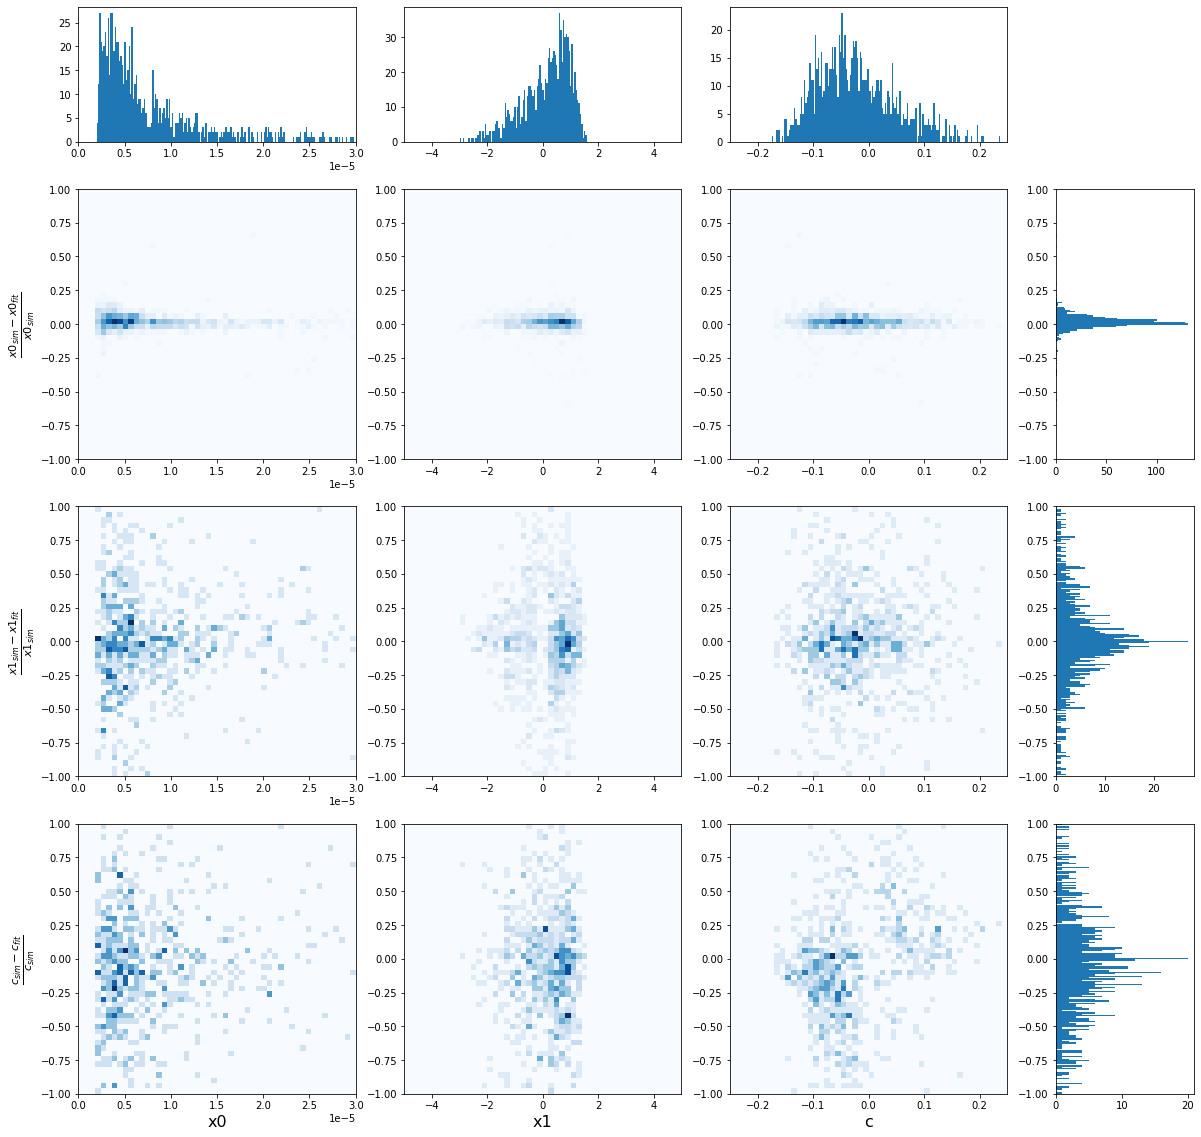

In [20]:
density_plot(sim_epoch_fit_4)


In [21]:
def plot_ra_dec(data, param, cmap='bwr'):
    """Plot normalized residuals on a sky map
    
    Args:
        data (DataFrame): Pipeline data to use for the plot
        param      (str): Name of the parameter to plot accuracy for
        cmap       (str): Name of the color map to use
    """
    
    resid = data[f'delta_{param}_norm']
    median_resid = resid.median()
    sn_coord = SkyCoord(data['ra'], data['dec'], unit=u.deg).galactic
    
    plt.figure(figsize=(10, 5))
    plt.subplot(111, projection='aitoff')
    plt.grid(True)

    scat = plt.scatter(
        sn_coord.l.wrap_at('180d').radian, 
        sn_coord.b.radian, c=resid, 
        vmin=-1 + median_resid, 
        vmax=1 + median_resid, 
        s=1, 
        cmap=cmap)
    
    plt.colorbar(scat).set_label(f'Accuracy in {param} (Median = {median_resid:.2f})', rotation=270, labelpad=15)


/home/djperrefort/miniconda3/envs/SN-PWV/lib/python3.9/site-packages/numpy/lib/function_base.py:3615: RuntimeWarning: invalid value encountered in true_divide
  return sin(y)/y


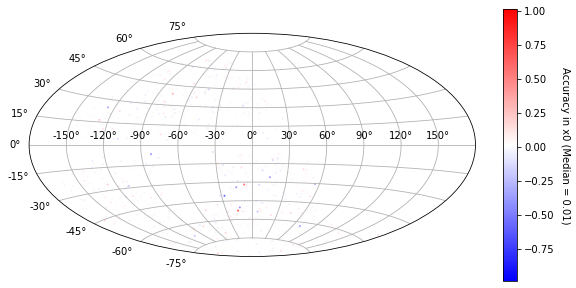

In [22]:
plot_ra_dec(sim_epoch_fit_4, 'x0')


/home/djperrefort/miniconda3/envs/SN-PWV/lib/python3.9/site-packages/numpy/lib/function_base.py:3615: RuntimeWarning: invalid value encountered in true_divide
  return sin(y)/y


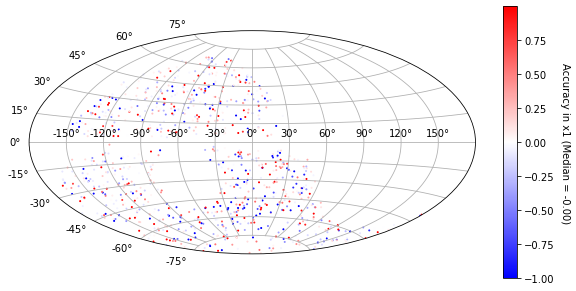

In [23]:
plot_ra_dec(sim_epoch_fit_4, 'x1')


/home/djperrefort/miniconda3/envs/SN-PWV/lib/python3.9/site-packages/numpy/lib/function_base.py:3615: RuntimeWarning: invalid value encountered in true_divide
  return sin(y)/y


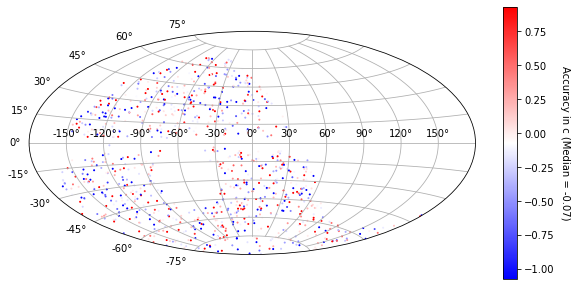

In [24]:
plot_ra_dec(sim_epoch_fit_4, 'c')
